In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [3]:
conn= sqlite3.connect("inventory.db")
df=pd.read_sql_query("Select* from Vendor_sales_summary",conn)
df.sample(5)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
9365,9552,M S WALKER INC,23863,Bisol Crede Prosseco Super V,14.38,20.99,750.0,12,172.56,12.0,263.88,109.95,1.34,55551.82,91.32,34.606639,1.000000,1.529207
5780,1392,CONSTELLATION BRANDS INC,44992,R Mondavi RSV Cab Svgn,67.56,119.99,750.0,39,2634.84,34.0,4193.66,3209.74,3.75,79528.99,1558.82,37.170872,0.871795,1.591618
10005,9744,FREDERICK WILDMAN & SONS,13604,Folonari Pnt Grigio Venezie,12.07,17.99,3000.0,8,96.56,0.0,0.00,0.00,0.00,3999.93,-96.56,-inf,0.000000,0.000000
548,3924,HEAVEN HILL DISTILLERIES,4563,Christian Bros Brandy,12.14,16.99,1750.0,9567,116143.38,9628.0,173593.72,112257.96,17695.67,14069.87,57450.34,33.094711,1.006376,1.494650
3492,4425,MARTIGNETTI COMPANIES,43308,Penfolds Koonunga Hil Shiraz,6.89,9.99,750.0,1792,12346.88,2209.0,26953.91,16567.44,245.00,144929.24,14607.03,54.192620,1.232701,2.183054


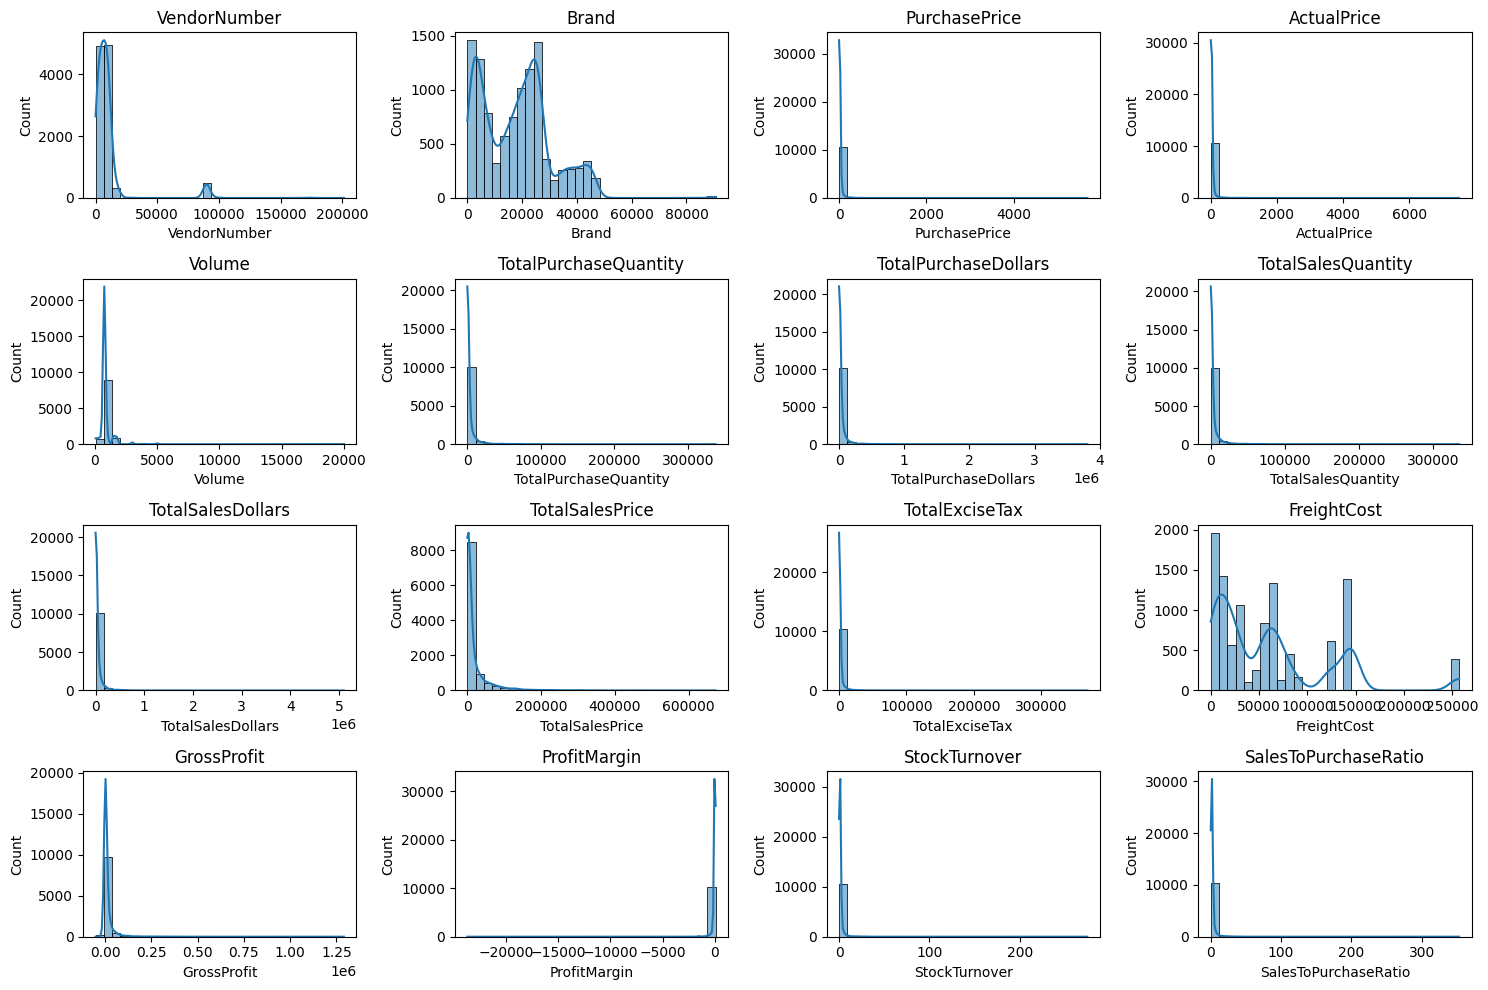

In [4]:
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()


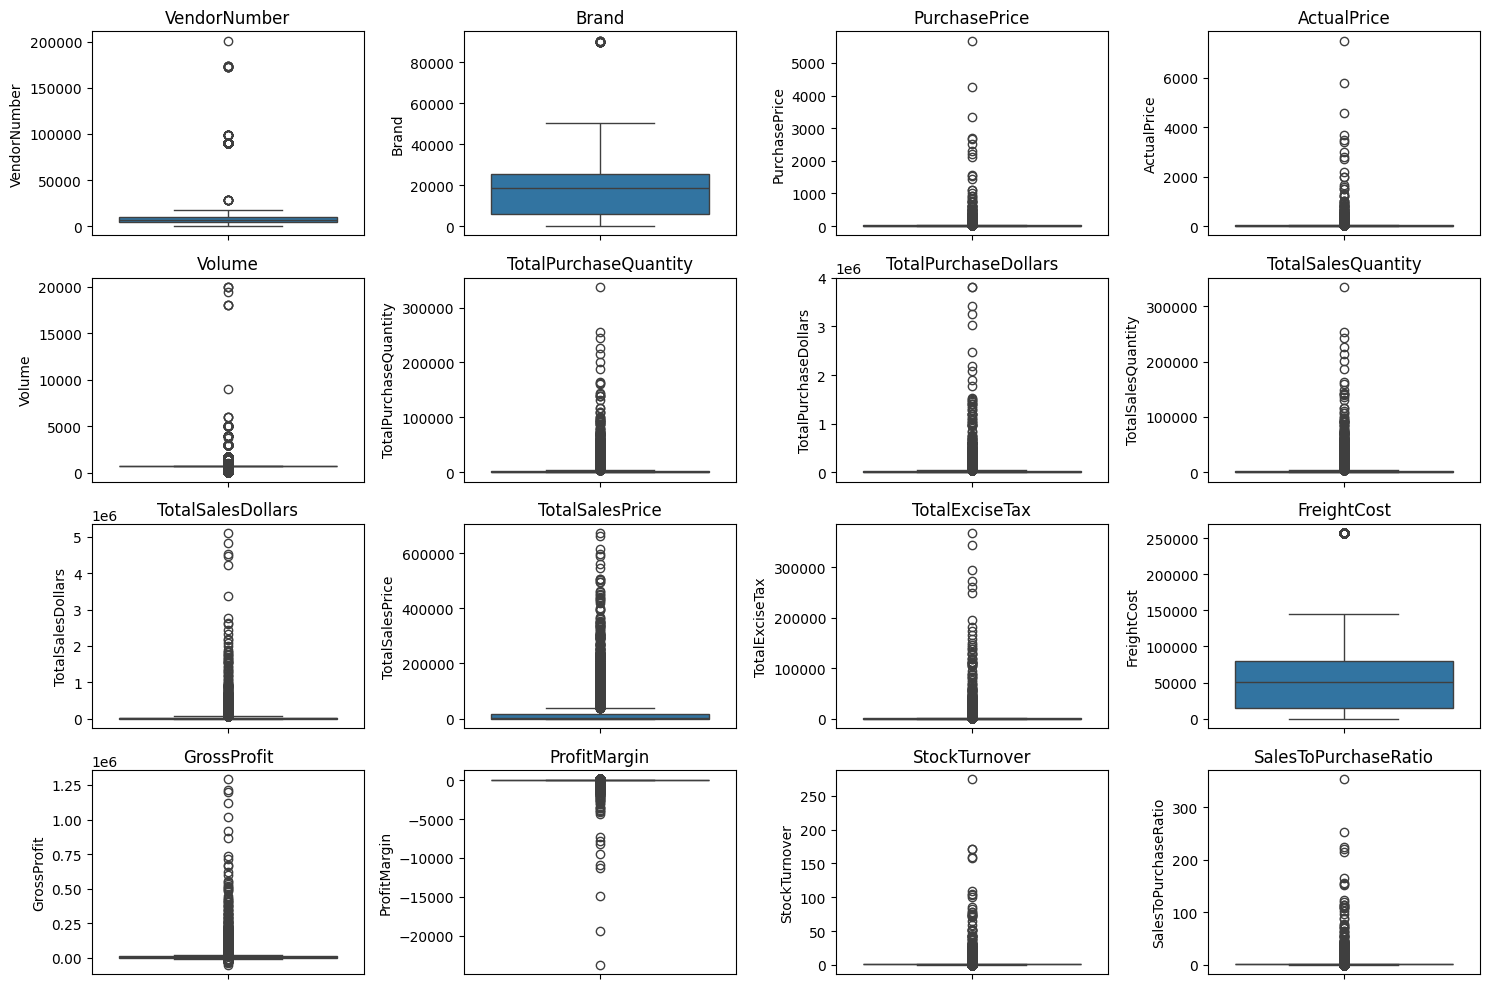

In [5]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [6]:
df = pd.read_sql_query("""
SELECT *
FROM vendor_sales_summary
WHERE GrossProfit > 0
AND ProfitMargin > 0
AND TotalSalesQuantity > 0
""", conn)


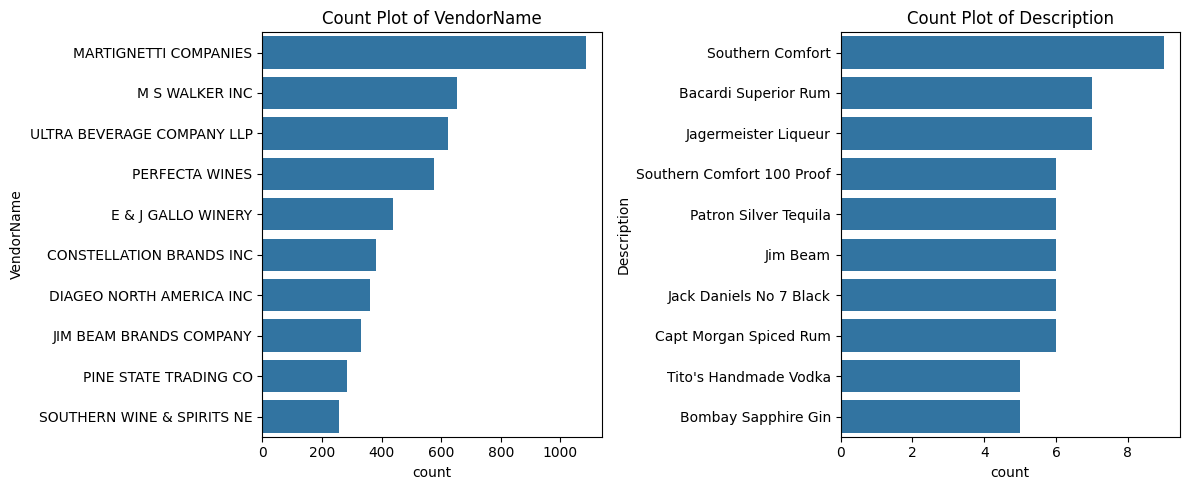

In [7]:
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f"Count Plot of {col}")

plt.tight_layout()
plt.show()


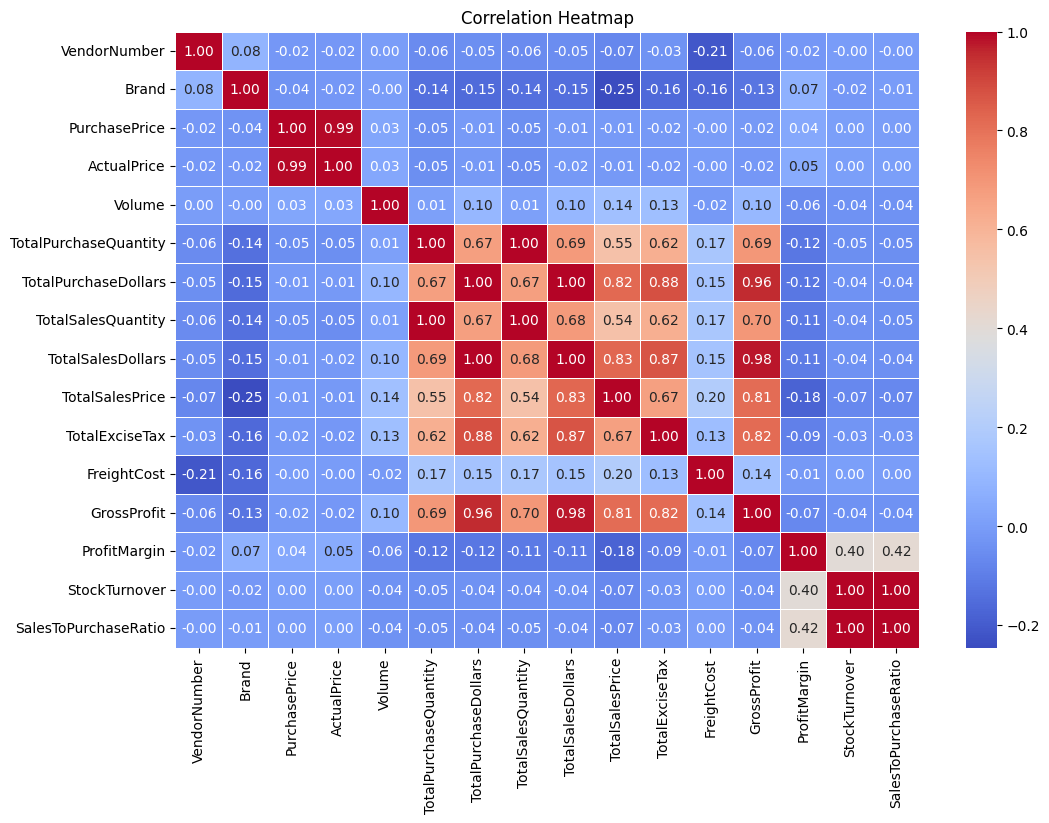

In [8]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()


In [9]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'}).reset_index()

In [10]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

low_sales_threshold

560.299

In [11]:
high_margin_threshold

64.97017552750111

In [12]:
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


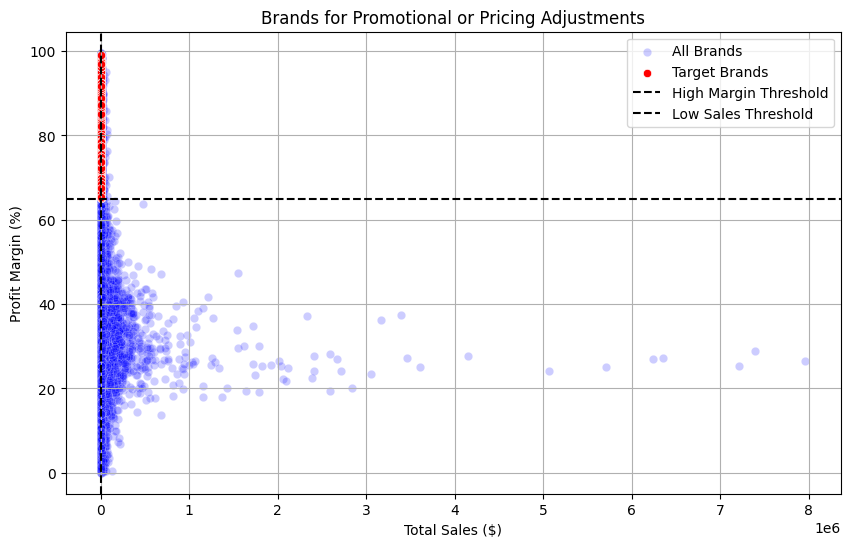

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha=0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

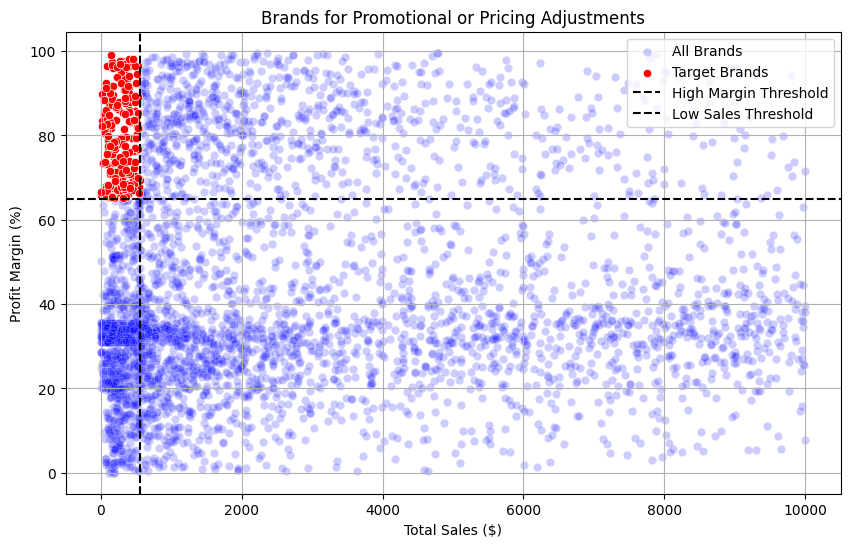

In [14]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000] # for better visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha=0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      6.799010e+07
MARTIGNETTI COMPANIES         3.933036e+07
PERNOD RICARD USA             3.206320e+07
JIM BEAM BRANDS COMPANY       3.142302e+07
BACARDI USA INC               2.485482e+07
CONSTELLATION BRANDS INC      2.421875e+07
E & J GALLO WINERY            1.839990e+07
BROWN-FORMAN CORP             1.824723e+07
ULTRA BEVERAGE COMPANY LLP    1.650254e+07
M S WALKER INC                1.470646e+07
Name: TotalSalesDollars, dtype: float64

In [16]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [17]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [18]:
top_brands=top_brands.apply(lambda x: format_dollars(x))
top_brands

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

In [20]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars':'sum',
    'GrossProfit':'sum',
    'TotalSalesDollars':'sum'
}).reset_index()

In [21]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars']/ vendor_performance['TotalPurchaseDollars'].sum()


In [22]:
vendor_performance = round(vendor_performance.sort_values('PurchaseContribution%', ascending = False), 2)

In [23]:
# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

C:\Users\nages\AppData\Local\Temp\ipykernel_21388\2774283761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
C:\Users\nages\AppData\Local\Temp\ipykernel_21388\2774283761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
C:\Users\nages\AppData\Local\Temp\ipykernel_21388\2774283761.py:5: SettingWithCopyWarning: 
A value 

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,0.16
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,0.08
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,0.08
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,0.08
6,BACARDI USA INC,17.43M,7.42M,24.85M,0.06
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,0.05
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,0.04
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,0.04
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,0.04
53,M S WALKER INC,9.76M,4.94M,14.71M,0.03


In [24]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()
top_vendors

C:\Users\nages\AppData\Local\Temp\ipykernel_21388\2063587715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()


,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,0.16,0.16
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,0.08,0.24
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,0.08,0.32
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,0.08,0.40
6,BACARDI USA INC,17.43M,7.42M,24.85M,0.06,0.46
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,0.05,0.51
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,0.04,0.55
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,0.04,0.59
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,0.04,0.63
53,M S WALKER INC,9.76M,4.94M,14.71M,0.03,0.66


In [25]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [26]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])

In [27]:
mean_unit_price_by_size = df.groupby('OrderSize')[['UnitPurchasePrice']].mean()
print(mean_unit_price_by_size)

           UnitPurchasePrice
OrderSize                   
Small              39.057543
Medium             15.486414
Large              10.777625


C:\Users\nages\AppData\Local\Temp\ipykernel_21388\2660026773.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_unit_price_by_size = df.groupby('OrderSize')[['UnitPurchasePrice']].mean()


C:\Users\nages\AppData\Local\Temp\ipykernel_21388\4260276710.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")


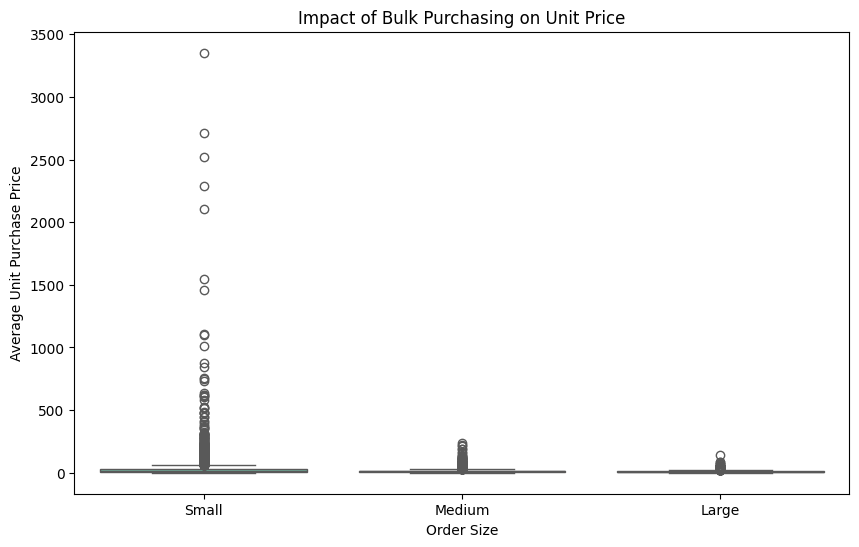

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

In [29]:
slow_moving_vendors = df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending = True).head(10)
slow_moving_vendors

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


In [30]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: 2.71M


In [31]:
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor["UnsoldInventoryValue"] = inventory_value_per_vendor["UnsoldInventoryValue"].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


In [34]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

In [35]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [36]:
def confidence_interval(data, confidence=0.95):
    
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) 
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)   
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


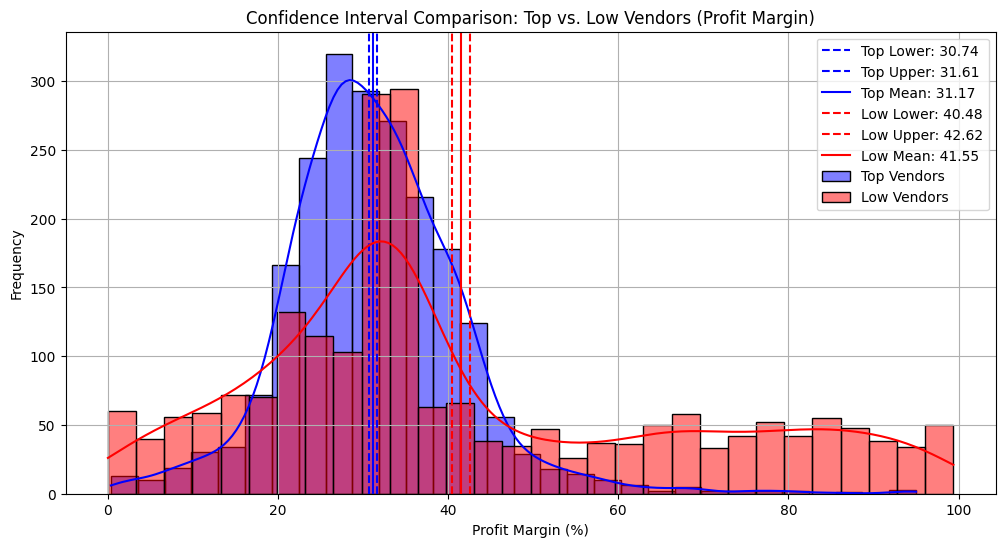

In [38]:
import scipy.stats as stats
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)


print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")
plt.figure(figsize=(12, 6))


sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")


plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")



sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")


plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")



plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()